
Class Distribution:
Erosion Risk
Medium    82
High      74
Low       59
Name: count, dtype: int64
Optimal Biofertilizer Formulation
Formulation B    82
Formulation D    41
Formulation A    39
Formulation C    37
Formulation E    16
Name: count, dtype: int64
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters: {'classifier__estimator__max_depth': 10, 'classifier__estimator__n_estimators': 200}

Cross-validated accuracy (train): 0.2400

=== Erosion Risk Evaluation ===
              precision    recall  f1-score   support

        High       0.33      0.27      0.30        22
         Low       0.36      0.50      0.42        18
      Medium       0.36      0.32      0.34        25

    accuracy                           0.35        65
   macro avg       0.35      0.36      0.35        65
weighted avg       0.35      0.35      0.35        65



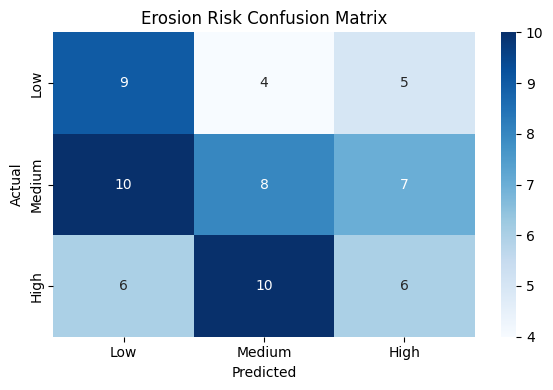


=== Optimal Biofertilizer Formulation Evaluation ===
               precision    recall  f1-score   support

Formulation A       0.10      0.10      0.10        10
Formulation B       0.53      0.38      0.44        26
Formulation C       0.14      0.15      0.15        13
Formulation D       0.07      0.08      0.07        12
Formulation E       0.14      0.25      0.18         4

     accuracy                           0.23        65
    macro avg       0.20      0.19      0.19        65
 weighted avg       0.28      0.23      0.25        65



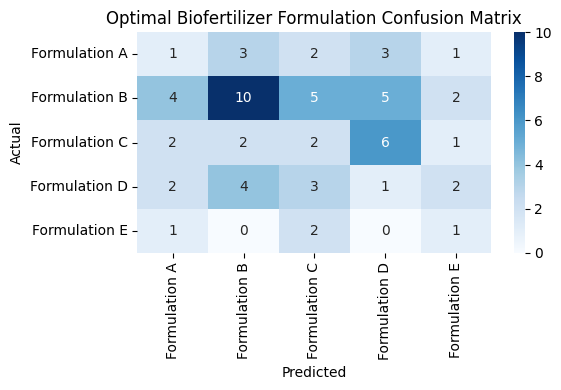

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier

# Load dataset
data = pd.read_csv('datasoil.csv')

data['Optimal Biofertilizer Formulation'] = data['Optimal Biofertilizer Formulation'].replace(
    'Formultaion E', 'Formulation E')

# Fix typo in Biofertilizer Formulation
data['Optimal Biofertilizer Formulation'] = data['Optimal Biofertilizer Formulation'].replace(
    'Formultaion E', 'Formulation E'
)

# Features and targets
X = data[['Soil Salinity (EC)', 'Soil pH', 'Organic Matter Content (%)',
          'Soil Moisture (%)', 'Nitrogen (mg/kg)', 'Phosphorus (mg/kg)',
          'Potassium (mg/kg)', 'Sand (%)', 'Silt (%)', 'Clay (%)',
          'Microbial Activity (CFU/g)', 'CEC (meq/100g)', 'SAR']]
y = data[['Erosion Risk', 'Optimal Biofertilizer Formulation']]

# Class distribution
print("\nClass Distribution:")
print(y['Erosion Risk'].value_counts())
print(y['Optimal Biofertilizer Formulation'].value_counts())

# Ordinal encoding
erosion_order = ['Low', 'Medium', 'High']
biofert_order = sorted(y['Optimal Biofertilizer Formulation'].dropna().unique())

encoder = OrdinalEncoder(categories=[erosion_order, biofert_order])
y_encoded = pd.DataFrame(encoder.fit_transform(y), columns=y.columns)

# Train-test split (stratified on Erosion Risk)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42,
    stratify=y_encoded[['Erosion Risk']]
)

# Preprocessing
numeric_features = X.columns.tolist()
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features)
])

# Balanced Random Forest for class imbalance
base_estimator = BalancedRandomForestClassifier(random_state=42, n_estimators=200)

# Final pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(base_estimator))
])

# Custom multi-output accuracy
def multioutput_accuracy(y_true, y_pred):
    y_pred_df = pd.DataFrame(y_pred, columns=y_true.columns)
    return np.mean([
        accuracy_score(y_true.iloc[:, i], y_pred_df.iloc[:, i])
        for i in range(y_true.shape[1])
    ])

custom_scorer = make_scorer(multioutput_accuracy, greater_is_better=True)

# Grid search parameters
param_grid = {
    'classifier__estimator__n_estimators': [100, 200],
    'classifier__estimator__max_depth': [5, 10]
}

# Grid search
grid_search = GridSearchCV(
    model, param_grid, cv=5, scoring=custom_scorer, n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")

# Cross-validation score
cv_scores = cross_val_score(best_model, X_train, y_train, scoring=custom_scorer, cv=5)
print(f"\nCross-validated accuracy (train): {cv_scores.mean():.4f}")

# Predict
y_pred = best_model.predict(X_test)
y_test_decoded = pd.DataFrame(encoder.inverse_transform(y_test), columns=y.columns)
y_pred_decoded = pd.DataFrame(encoder.inverse_transform(y_pred), columns=y.columns)

# Evaluation reports & confusion matrices
for target in y.columns:
    print(f"\n=== {target} Evaluation ===")
    print(classification_report(y_test_decoded[target], y_pred_decoded[target]))

    labels = encoder.categories_[y.columns.get_loc(target)]
    cm = confusion_matrix(y_test_decoded[target], y_pred_decoded[target], labels=labels)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"{target} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
